# Import Library

In [1]:
# Data Loading
import xarray as xr  

# Data Processing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Ignore warning messages
import warnings
warnings.filterwarnings(action='ignore')

# Data Load

In [2]:
# http://research.jisao.washington.edu/data_sets/ndvi/
path = './ndviavhrr19812001.nc'

ncfile = xr.open_dataset(path)
print(ncfile) # print dataset infomation 

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 252)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:     \nNational Aeronautics and Space Administration advanced ver...
    title:       NASA AVHRR normalized difference vegetation index, 1981-2001
    convention:  The file is written in COARDS-compliant netCDF:\nftp://ftp.u...


# Data Processing

In [3]:
# select variable
ndvi = ncfile.data_vars['data']
print(ndvi.shape)  # [time, lat, lon]

(252, 180, 360)


In [4]:
# Convert longitude coordinates from 0-359 to -180-179:
# http://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html

ndvi_ = ndvi.assign_coords({"lon": (((ndvi.lon + 180) % 360) - 180)})
ndvi_ = ndvi_.sortby('lon')

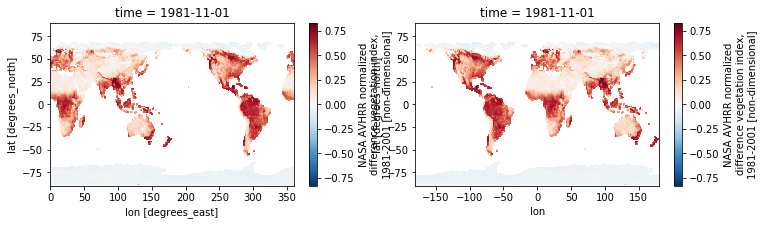

In [5]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1) ;ndvi[10].plot()
plt.subplot(1,2,2) ;ndvi_[10].plot()

In [6]:
# Africa domain
africa = ndvi_.sel(lon=slice(-30,60), lat=slice(40,-40))
print(africa.shape)

(252, 80, 90)


In [7]:
# climatology
africa_clim = africa.groupby("time.month").mean('time')
print(africa_clim.shape)

# anomaly
africa_anom = africa_clim - africa_clim.mean('month')
print(africa_anom.shape)

(12, 80, 90)
(12, 80, 90)


In [8]:
def weighted_sum(x, axis):
    weight = [-1, 1, 0]
    if x.shape[axis] == 3:
        return np.nansum(x*weight, axis=axis)
    else:
        print('correct time interval')
        return np.nan

In [9]:
# seasonal progression
africa_prog = africa.rolling(time=3, center=True).reduce(weighted_sum)
africa_prog_clim = africa_prog.groupby("time.month").mean('time')
print(africa_prog_clim.shape)

(12, 80, 90)


# Visualization

In [10]:
def plot_africa_ndvi(ax, x, title, vmax, vmin):
    
    m = Basemap(
        lon_0=0, lat_0=0, # center of mat domain
        llcrnrlon=x.lon[0], llcrnrlat=x.lat[-1], urcrnrlon=x.lon[-1], urcrnrlat=x.lat[0], # projection region
        resolution='l', # boundary resolution (c, l, i, h, f)
        ax=ax
    )
    
    ax.set_title(title)
    
    coord = np.meshgrid(x.lon, x.lat)
    m.drawcoastlines(linewidth=0.5, color='k') # draw coastline
    m.drawcountries(linewidth=0.5, color='k') # draw coastline
    c = m.contourf(coord[0], coord[1], x,
               cmap=plt.cm.BrBG,
               levels=20,
               vmax=vmax, vmin=vmin,
              )
    
    return c

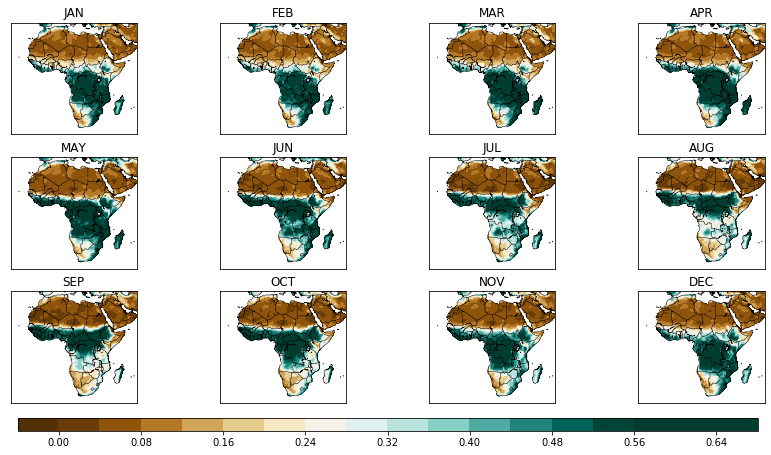

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,7))
plt.subplots_adjust(wspace=0.0, hspace=0.2)

title = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

t=0
for r in range(3):
    for c in range(4):
        plot = plot_africa_ndvi(ax[r][c], africa_clim[t], title[t], vmax=0.55, vmin=0.0)
        t+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation="horizontal")

plt.show()

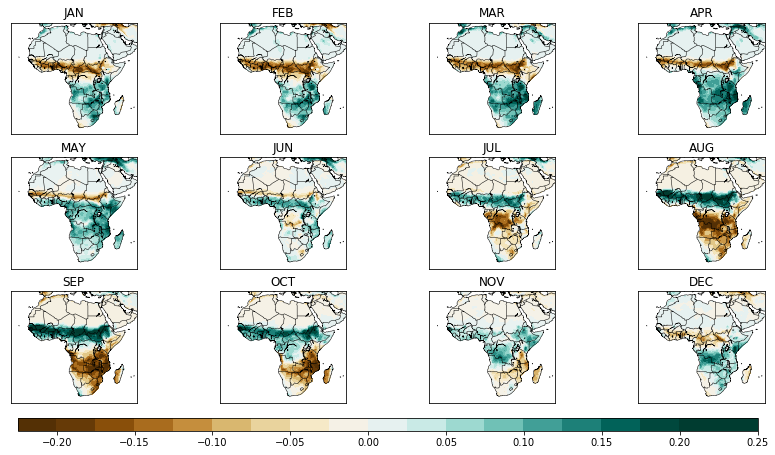

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,7))
plt.subplots_adjust(wspace=0.0, hspace=0.2)

title = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

t=0
for r in range(3):
    for c in range(4):
        plot = plot_africa_ndvi(ax[r][c], africa_anom[t], title[t], vmax=0.2, vmin=-0.2)
        t+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation="horizontal")

plt.show()

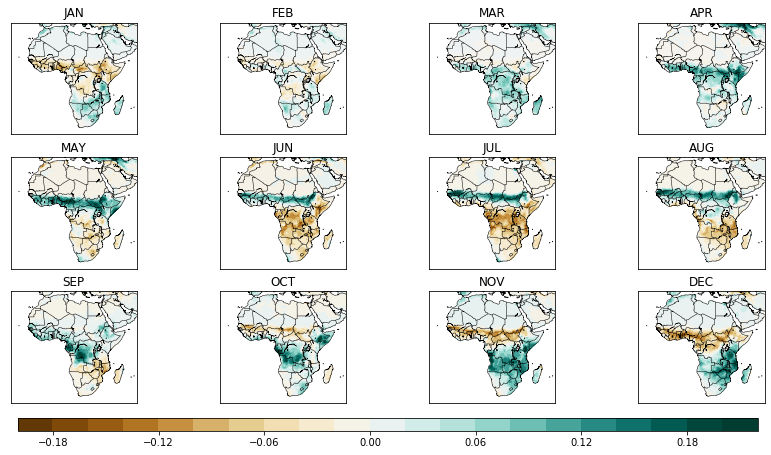

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,7))
plt.subplots_adjust(wspace=0.0, hspace=0.2)

title = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

t=0
for r in range(3):
    for c in range(4):
        plot = plot_africa_ndvi(ax[r][c], africa_prog_clim[t], title[t], vmax=0.2, vmin=-0.2)
        t+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation="horizontal")

plt.show()